# Bayesian Search Algorithm

Use bayesian search based on the paper: "Bayesian-Based Search Decision Framework and Search Strategy Analysis in Probabilistic Search"

link: https://onlinelibrary.wiley.com/doi/full/10.1155/2020/8865381

In [255]:
# Import necessary libraries
import matplotlib.pyplot as plt
import networkx as nx
import random
import re
import xml.etree.ElementTree as ET

In [ ]:
# Constants
map_graph_path = "../graphs/original/final_graph.graphml" # .graphml file path
start_node = "n138"   # Start position (node)
target_node = "n515" # target's (ring) position (node)

p_tp = 0.8  # P(true positive)
p_fp = 0.2  # P(false positive)
p_tn = 0.9  # P(true negative)
p_fn = 0.1  # P(false negative)
B_lower = 0  # Lower boundary for maximum belief
B_upper = 1   # Upper boundary for maximum belief
max_steps = 213  # Maximum number of steps

# May I say "Fuck this paper's notations. What the fuck do you mean by 3 same equations having 3 distinct values??? What the hell is this level of inconsistency in naming variables???."

In [203]:
# Generic helper functions

# Display graph information
def display_graph_information(graph):
    # Print nodes data
    for node, data in graph.nodes(data=True):
        print(f"Node: {node}, Attributes: {data}")

    # Print edges data
    for u, v, data in graph.edges(data=True):
        print(f"Edge: ({u}, {v}), Attributes: {data}")

    print("Number of Nodes:", len(graph.nodes()))
    print("Number of Edges:", len(graph.edges()))

def add_edges_weight(graph):
    for u, v, data in graph.edges(data=True):
        data['weight'] = 1.0  # Assign a weight of 1 to each edge

In [204]:
# Set target (ring) position (node)
def set_target_node(graph, target_node_id):
    nx.set_node_attributes(graph, {target_node_id: {"target": True}})

In [205]:
# Bayesian search for incomplete information sensor

# Create an initial belief map
def initialize_belief_map(graph, choice, suspected_nodes=[]):
    """
        Choice:
            0: Uniform Belief Map
            1: Randomized Belief Map
            2: Peak (require suspected_node)
            3: Normal Distribution Map (require suspected_node)
    """
    num_nodes = len(graph.nodes())

    if choice == 0:
        uniform_belief = 1.0 / num_nodes

        for node in graph.nodes():
            graph.nodes[node]["P(target)"] = uniform_belief
    elif choice == 1:
        for node in graph.nodes():
            graph.nodes[node]["P(target)"] = random.uniform(0.0, 1.0)
    elif choice == 2 and len(suspected_nodes) > 0:
        suspected_belief = 1.0 / len(suspected_nodes)
        general_belief = 1.0 / (num_nodes - len(suspected_nodes))
        
        for node in graph.nodes():
            graph.nodes[node]["P(target)"] = general_belief
        for suspected_node in suspected_nodes:
            graph.nodes[suspected_node]["P(target)"] = suspected_belief
        
    elif choice == 3 and len(suspected_nodes) > 0:
        sd = 1 
        mean = 0.5


# Implement the Dijkstra algorithm
def dijkstra_search(graph, start_node, target_node):
    try:
        path = nx.dijkstra_path(graph, source=start_node, target=target_node, weight='weight')
        
        return path
    except nx.NetworkXNoPath:
        print(f"No path found between {start_node} and {target_node}.")
        return []

# Update the belief map
def update_belief_map(graph, agent_node, observation):
    total_nodes = len(graph.nodes())
    new_beliefs = {}
    
    # Calculate the denominator for the Bayesian update (marginal probability)
    denominator = 0.0

    for node in graph.nodes():
        prior_prob = graph.nodes[node]["P(target)"]

        if node == agent_node:
            if observation:
                denominator += prior_prob * p_tp  # P(O | D_d) * P(D_d)
            else:
                denominator += prior_prob * p_fn  # P(~O | D_d) * P(D_d)
        else:
            if observation:
                denominator += prior_prob * p_fp  # P(O | D_c) * P(D_c)
            else:
                denominator += prior_prob * p_tn  # P(~O | D_c) * P(D_c)

    # Quit if denominator = 0
    if denominator == 0:
        return

    # Updated probabilities
    new_beliefs = {}

    for node in graph.nodes():
        prior_prob = graph.nodes[node]["P(target)"]

        if node == agent_node:
            if observation:
                numerator = prior_prob * p_tp  # P(D_d | O)
            else:
                numerator = prior_prob * p_fn  # P(D_d | ~O)
        else:
            if observation:
                numerator = prior_prob * p_fp  # P(D_c | O)
            else:
                numerator = prior_prob * p_tn  # P(D_c | ~O)
                
        updated_prob = numerator / denominator
        new_beliefs[node] = updated_prob

    # Assign the new beliefs to the graph nodes
    nx.set_node_attributes(graph, new_beliefs, "P(target)")

# Modified saccadic search strategy
def saccadic_search_strategy(graph, start_node, max_steps, target_node, suspected_nodes=[]):
    current_node = start_node
    path_taken = [current_node]
    target_found = False
    count = 1
    
    # Initialize with uniform belief
    if len(suspected_nodes) == 0:
        initialize_belief_map(graph, choice=0)
    elif len(suspected_nodes) > 0:
        initialize_belief_map(graph, choice=2, suspected_nodes=suspected_nodes)

    current_path = []
    
    for step in range(max_steps):
        # print(f"Step: {step + 1}")
        
        # Check if we have reached our planned destination and need a new one
        if not current_path:
            # Find the node with the highest belief
            highest_belief_node = max(graph.nodes(data='P(target)'), key=lambda x: x[1])[0]
            
            # print(f"New target destination identified: {highest_belief_node}.")
            
            # Plan a new path to the highest belief node
            current_path = dijkstra_search(graph, current_node, highest_belief_node)
            
            # If no path is found, break the loop
            if not current_path:
                # print(f"No path found to {highest_belief_node}.")
                
                break
                
            # The first element is the current node, we want to move to the next.
            if len(current_path) > 1:
                current_path.pop(0)

        # Move to the next node on the path
        if current_path:
            next_node = current_path.pop(0)

            # print(f"Moving from {current_node} to {next_node}")

            current_node = next_node

            path_taken.append(current_node)
        
        # Perform observation and update belief at the new location
        is_target = graph.nodes[current_node].get("target", False)
        
        if is_target:
            observation = random.random() < p_tp   # True positive with probability p_tp
        else:
            observation = random.random() < p_fp   # False positive with probability p_fp
        
        update_belief_map(graph, current_node, observation)
        # print(f"At {current_node}. Belief at this node is {graph.nodes[current_node]['P(target)']:.4f}")

        # Check for target presence. We check at every step because we're moving and observing.
        if current_node == target_node:
            #  print(f"Target found at {current_node}!")

             target_found = True

             break
        
        count+=1
    
    print("Number of steps taken: ", count)
    
    return path_taken, target_found, count

In [206]:
LABEL_RE = re.compile(r"^\s*-?\d+\s*,\s*-?\d+\s*$")
NS = {
    "g": "http://graphml.graphdrawing.org/xmlns",
    "y": "http://www.yworks.com/xml/graphml",
}
map_graph_path = "../mapGraphs/graphml/HIMCM_graph_FINAL.graphml" # .graphml file path

def inject_node_labels_from_graphml_file(G, graphml_path, label_attr="node_label"):
    tree = ET.parse(str(graphml_path))
    root = tree.getroot()
 
    for n in root.findall(".//g:graph/g:node", NS):
        nid = n.get("id")
        if nid not in G:  # only inject for nodes that exist in this graph
            continue
 
        txt = None
        for d in n.findall("./g:data", NS):
            lab = d.find("./y:ShapeNode/y:NodeLabel", NS)
            if lab is None:
                lab = d.find("./y:GenericNode/y:NodeLabel", NS)
            if lab is not None and lab.text:
                txt = lab.text.strip()
                break
 
        # If it's a coordinate-like label, use it; otherwise keep any existing value
        if txt and LABEL_RE.match(txt):
            G.nodes[nid][label_attr] = txt
 
def nodes_to_labels(G, node_id_path, label_attr="node_label"):
    return [G.nodes[nid].get(label_attr, str(nid)) for nid in node_id_path]

In [207]:
# Read .graphml file
map_graph = nx.read_graphml(map_graph_path)

display_graph_information(map_graph)

Node: n0, Attributes: {'x': '539.7320177831189', 'y': '814.3710124080101', 'shape_type': 'ellipse', 'label': '16,11'}
Node: n1, Attributes: {'x': '491.39296206082173', 'y': '814.701509196422', 'shape_type': 'ellipse', 'label': '16,10'}
Node: n2, Attributes: {'x': '540.242019608562', 'y': '765.0825618080634', 'shape_type': 'ellipse', 'label': '15,11'}
Node: n3, Attributes: {'x': '589.4380120008074', 'y': '813.8610105825668', 'shape_type': 'ellipse', 'label': '16,12'}
Node: n4, Attributes: {'x': '491.50793350674974', 'y': '764.5725599826202', 'shape_type': 'ellipse', 'label': '15,10'}
Node: n5, Attributes: {'x': '539.5620171746378', 'y': '862.7626250900943', 'shape_type': 'ellipse', 'label': '17,11'}
Node: n6, Attributes: {'x': '490.88296023537856', 'y': '862.2526232646511', 'shape_type': 'ellipse', 'label': '17,10'}
Node: n7, Attributes: {'x': '590.2080004396669', 'y': '764.5725599826202', 'shape_type': 'ellipse', 'label': '15,12'}
Node: n8, Attributes: {'x': '589.0179961802995', 'y': '

In [208]:
# Run the search and get results
print("\nStarting Saccadic Search...")
suspected_nodes = []
#suspected_nodes = ["n515"]
#suspected_nodes = ["n478", "n562", "n178", "n154"]
search_path, found, count = saccadic_search_strategy(map_graph, start_node, max_steps, target_node, suspected_nodes=suspected_nodes)

print("\nSearch Results:")  

if found:
    print("Target was found!")
else:
    print("Target was not found within the maximum number of steps.")
    
print("Search path:", search_path)


Starting Saccadic Search...
Number of steps taken:  145

Search Results:
Target was found!
Search path: ['n138', 'n131', 'n140', 'n147', 'n149', 'n12', 'n4', 'n0', 'n0', 'n4', 'n12', 'n149', 'n147', 'n140', 'n147', 'n149', 'n12', 'n14', 'n1', 'n14', 'n4', 'n2', 'n3', 'n5', 'n6', 'n0', 'n7', 'n3', 'n8', 'n0', 'n2', 'n9', 'n10', 'n2', 'n11', 'n14', 'n13', 'n6', 'n15', 'n8', 'n16', 'n3', 'n0', 'n6', 'n17', 'n6', 'n0', 'n2', 'n10', 'n18', 'n16', 'n19', 'n16', 'n89', 'n20', 'n89', 'n16', 'n8', 'n5', 'n21', 'n21', 'n21', 'n21', 'n5', 'n22', 'n5', 'n21', 'n23', 'n21', 'n5', 'n8', 'n24', 'n8', 'n5', 'n21', 'n23', 'n44', 'n28', 'n25', 'n25', 'n28', 'n44', 'n33', 'n30', 'n26', 'n26', 'n27', 'n27', 'n29', 'n29', 'n26', 'n31', 'n25', 'n32', 'n34', 'n35', 'n34', 'n36', 'n37', 'n39', 'n38', 'n38', 'n31', 'n40', 'n33', 'n41', 'n33', 'n30', 'n31', 'n42', 'n31', 'n30', 'n33', 'n41', 'n43', 'n41', 'n33', 'n30', 'n25', 'n32', 'n45', 'n32', 'n25', 'n30', 'n46', 'n46', 'n40', 'n47', 'n40', 'n46', 'n48', '

In [ ]:
# Unused code
for searched_node in search_path:
    for node, data in map_graph.nodes(data=True):
        if searched_node == node:
            print(f"Node: {node}, Attributes: {data}")
            print("X:", int(float(data["x"]) / 50))
            print("Y:", int(float(data["y"]) / 50))

Node: n138, Attributes: {'x': '201.34244411651133', 'y': '573.5505850318488', 'shape_type': 'ellipse', 'label': '11,4', 'P(target)': 0.0014938929314243217}
X: 4
Y: 11
Node: n131, Attributes: {'x': '248.3117094752992', 'y': '621.4321958884899', 'shape_type': 'ellipse', 'label': '12,5', 'P(target)': 0.00016598810349159132}
X: 4
Y: 12
Node: n140, Attributes: {'x': '298.1568643383582', 'y': '671.3473589934093', 'shape_type': 'ellipse', 'label': '13,6', 'P(target)': 0.0006639524139663653}
X: 5
Y: 13
Node: n147, Attributes: {'x': '348.52692343292597', 'y': '672.0426453477386', 'shape_type': 'ellipse', 'label': '13,7', 'P(target)': 2.049235845575202e-06}
X: 6
Y: 13
Node: n149, Attributes: {'x': '393.4297248471613', 'y': '670.3824831555406', 'shape_type': 'ellipse', 'label': '13,8', 'P(target)': 2.049235845575202e-06}
X: 7
Y: 13
Node: n12, Attributes: {'x': '443.9136948765907', 'y': '718.5026128475819', 'shape_type': 'ellipse', 'label': '14,9', 'P(target)': 2.049235845575202e-06}
X: 8
Y: 14
No

## Test Cases

### Static Test

In [ ]:
# Constants
start_nodes = ["n0", "n20", "n33", "n200", "n555"]
target_nodes = ["n20", "n22", "n576", "n714", "n123"]
max_steps = 213

In [ ]:
# Static test
def static_test(graph, start_nodes, target_nodes):
    count_found = 0
    count_steps = 0

    for start_node, target_node in zip(start_nodes, target_nodes):
        print("Start Node: " + start_node, "Target Node: " + target_node)

        search_path, found, steps = saccadic_search_strategy(graph, start_node, max_steps, target_node)
        
        if found:
            count_found+=1
            count_steps+=steps

        inject_node_labels_from_graphml_file(graph, map_graph_path, label_attr="y:LabelModel")

        path_labels = nodes_to_labels(graph, search_path, label_attr="y:LabelModel")
        
        print("Path (labels):", " -> ".join(path_labels))
        print("Target found:", found)

        
    return count_found, count_steps

In [212]:
map_graph = nx.read_graphml(map_graph_path)

static_test(map_graph, start_nodes, target_nodes)

Start Node: n0 Target Node: n20
Number of steps taken:  45
Path (labels): 16,11 -> 16,11 -> 16,10 -> 16,10 -> 15,11 -> 16,12 -> 16,11 -> 15,10 -> 15,10 -> 16,10 -> 17,11 -> 17,10 -> 16,11 -> 15,12 -> 16,12 -> 17,12 -> 16,11 -> 15,11 -> 14,11 -> 14,12 -> 15,11 -> 14,10 -> 14,9 -> 15,9 -> 16,9 -> 17,10 -> 18,11 -> 17,12 -> 16,13 -> 16,12 -> 16,11 -> 17,10 -> 17,9 -> 17,10 -> 16,11 -> 15,11 -> 14,12 -> 15,13 -> 16,13 -> 17,13 -> 17,13 -> 17,13 -> 17,13 -> 16,13 -> 15,14 -> 14,13
Target found: True
Start Node: n20 Target Node: n22
Number of steps taken:  60
Path (labels): 14,13 -> 14,12 -> 15,11 -> 16,11 -> 15,11 -> 16,10 -> 16,11 -> 16,12 -> 16,11 -> 15,10 -> 16,10 -> 17,11 -> 17,10 -> 17,10 -> 16,11 -> 15,12 -> 16,12 -> 17,12 -> 16,11 -> 15,11 -> 14,11 -> 14,10 -> 14,10 -> 14,10 -> 14,10 -> 14,10 -> 14,10 -> 14,10 -> 14,9 -> 15,9 -> 16,9 -> 16,9 -> 17,10 -> 18,11 -> 17,12 -> 16,13 -> 16,12 -> 16,11 -> 17,10 -> 17,9 -> 17,10 -> 16,11 -> 15,11 -> 14,12 -> 15,13 -> 16,13 -> 17,13 -> 17,13 -

(2, 105)

### Random Test

In [ ]:
# Constants
number_of_test_cases = 5
max_steps = 213

In [ ]:
# Random start and target node test
def random_test(graph, number_of_test_cases):
    number_of_nodes = len(graph.nodes())
    start_nodes = []
    target_nodes = []

    for i in range(number_of_test_cases):
        start_nodes.append("n" + str(random.randint(0, number_of_nodes)))
        target_nodes.append(("n" + str(random.randint(0, number_of_nodes - 1))))
    
    count_found, count_steps = static_test(graph, start_nodes, target_nodes)

    return count_found, count_steps

In [215]:
map_graph = nx.read_graphml(map_graph_path)

random_test(map_graph, number_of_test_cases)

Start Node: n606 Target Node: n86
Number of steps taken:  214
Path (labels): 23,2 -> 23,3 -> 23,4 -> 22,5 -> 22,6 -> 21,7 -> 21,8 -> 20,9 -> 19,10 -> 18,9 -> 17,10 -> 16,11 -> 17,10 -> 17,10 -> 17,10 -> 17,10 -> 17,10 -> 18,9 -> 18,9 -> 18,9 -> 18,9 -> 18,9 -> 18,9 -> 18,9 -> 19,10 -> 20,9 -> 21,8 -> 21,7 -> 21,7 -> 21,8 -> 20,9 -> 19,10 -> 18,9 -> 17,10 -> 18,9 -> 19,10 -> 20,9 -> 21,8 -> 21,7 -> 21,7 -> 21,8 -> 20,9 -> 19,10 -> 18,9 -> 17,10 -> 16,10 -> 15,11 -> 16,12 -> 16,11 -> 15,10 -> 16,10 -> 17,11 -> 16,11 -> 15,12 -> 16,12 -> 17,12 -> 17,12 -> 16,11 -> 15,11 -> 14,11 -> 14,11 -> 14,12 -> 15,11 -> 14,10 -> 15,11 -> 15,10 -> 14,9 -> 15,9 -> 16,9 -> 17,10 -> 18,11 -> 17,12 -> 16,13 -> 17,12 -> 17,11 -> 18,10 -> 17,9 -> 17,10 -> 16,11 -> 15,11 -> 14,12 -> 15,13 -> 16,13 -> 17,13 -> 16,13 -> 15,14 -> 14,13 -> 15,14 -> 16,13 -> 17,13 -> 18,12 -> 18,13 -> 17,12 -> 17,11 -> 18,10 -> 18,9 -> 17,8 -> 16,7 -> 16,6 -> 16,6 -> 16,5 -> 15,6 -> 15,5 -> 16,6 -> 17,6 -> 17,5 -> 17,5 -> 17,5 ->

(0, 0)

### Random Suspected Nodes Test

In [ ]:
# Randomize suspected nodes
def random_suspected_nodes(graph, number_of_suspected_nodes):
    number_of_nodes = len(graph.nodes())
    suspected_nodes = []

    for i in range(number_of_suspected_nodes):
        suspected_nodes.append("n" + str(random.randint(0, number_of_nodes - 1)))

    return suspected_nodes

def static_random_suspected_nodes_test(graph, start_node, target_node, number_of_test_cases):
    percent_found_list = []
    average_steps_list = []

    print("Start Node: " + start_node, "Target Node: " + target_node)

    for i in range(10):
        count_found = 0
        count_steps = 0

        for j in range(number_of_test_cases):
            suspected_nodes = random_suspected_nodes(graph, i)
            search_path, found, steps = saccadic_search_strategy(graph, start_node, max_steps, target_node, suspected_nodes=suspected_nodes)
            
            print("Suspected Nodes:", suspected_nodes)

            if found:
                count_found+=1
                count_steps+=steps

            inject_node_labels_from_graphml_file(graph, map_graph_path, label_attr="y:LabelModel")

            path_labels = nodes_to_labels(graph, search_path, label_attr="y:LabelModel")
            
            print("Path (labels):", " -> ".join(path_labels))
            print("Target found:", found)

        percent_found = float(count_found / number_of_test_cases) * 100
        average_steps = float(count_steps / count_found)

        percent_found_list.append(percent_found)
        average_steps_list.append(average_steps)

        print("\nFound:", str(count_found) + '/' + str(number_of_test_cases), ", Percent:", percent_found)
        print("Average steps used:", average_steps, '\n')       

         

    return percent_found_list, average_steps_list

In [251]:
map_graph = nx.read_graphml(map_graph_path)

percent_found_list, average_steps_list = static_random_suspected_nodes_test(map_graph, start_node, target_node, number_of_test_cases=100)

Start Node: n138 Target Node: n515
Number of steps taken:  128
Suspected Nodes: []
Path (labels): 11,4 -> 12,5 -> 13,6 -> 13,7 -> 13,8 -> 14,9 -> 15,10 -> 16,11 -> 15,10 -> 14,9 -> 15,9 -> 16,10 -> 15,9 -> 15,10 -> 15,11 -> 16,12 -> 16,12 -> 17,11 -> 17,10 -> 16,11 -> 15,12 -> 16,12 -> 17,12 -> 16,11 -> 15,11 -> 14,11 -> 14,12 -> 15,11 -> 14,10 -> 15,9 -> 16,9 -> 17,10 -> 18,11 -> 17,12 -> 16,13 -> 16,12 -> 16,11 -> 17,10 -> 17,9 -> 17,10 -> 16,11 -> 15,11 -> 14,12 -> 15,13 -> 16,13 -> 17,13 -> 16,13 -> 15,14 -> 14,13 -> 14,12 -> 15,11 -> 16,11 -> 17,10 -> 18,10 -> 18,10 -> 17,11 -> 16,11 -> 15,11 -> 14,12 -> 15,11 -> 16,11 -> 17,11 -> 18,12 -> 18,12 -> 17,11 -> 18,10 -> 18,9 -> 18,9 -> 18,10 -> 17,11 -> 17,12 -> 18,13 -> 18,13 -> 17,12 -> 17,11 -> 18,10 -> 18,9 -> 17,8 -> 16,7 -> 16,6 -> 16,5 -> 15,6 -> 15,5 -> 15,5 -> 16,6 -> 17,6 -> 17,5 -> 16,6 -> 15,7 -> 16,8 -> 17,7 -> 16,6 -> 15,6 -> 14,6 -> 14,7 -> 14,6 -> 14,5 -> 14,4 -> 15,4 -> 16,4 -> 17,5 -> 18,6 -> 18,5 -> 17,4 -> 17,5 -> 

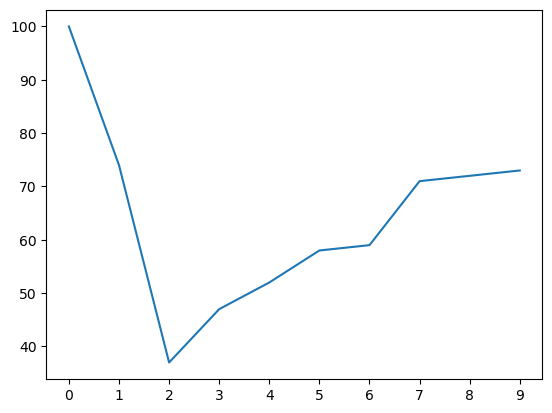

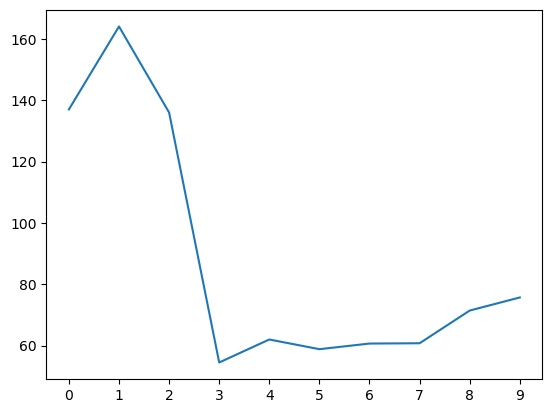

Percent Found List: [100.0, 74.0, 37.0, 47.0, 52.0, 57.99999999999999, 59.0, 71.0, 72.0, 73.0]
Average Steps List: [136.98, 164.01351351351352, 135.97297297297297, 54.51063829787234, 62.0, 58.8448275862069, 60.67796610169491, 60.774647887323944, 71.43055555555556, 75.6986301369863]


In [266]:
# Display percent found for each number of suspected nodes
plt.plot(percent_found_list)
plt.xticks(range(10))
plt.show()
plt.close()

# Display average steps taken for each number of suspected nodes of successful attempts
plt.plot(average_steps_list)
plt.xticks(range(10))
plt.show()
plt.close()

print("Percent Found List:", percent_found_list)
print("Average Steps List:", average_steps_list)

## Generate Result

### Uniform Test (no previous information path is known)

In [ ]:
# Uniform probability test
def uniform_test(graph, start_node):
    number_of_nodes = len(graph.nodes())
    start_nodes = []
    target_nodes = []

    for i in range(number_of_nodes):
        start_nodes.append(start_node)
        target_nodes.append(("n" + str(i)))
    
    count_found, count_steps = static_test(graph, start_nodes, target_nodes)

    print("\nFound:", str(count_found) + '/' + str(number_of_nodes), ", Percent:", float(count_found / number_of_nodes) * 100)
    print("Average steps used:", float(count_steps / count_found))

In [225]:
map_graph = nx.read_graphml(map_graph_path)

uniform_test(map_graph, start_node)

Start Node: n138 Target Node: n0
Number of steps taken:  7
Path (labels): 11,4 -> 12,5 -> 13,6 -> 13,7 -> 13,8 -> 14,9 -> 15,10 -> 16,11
Target found: True
Start Node: n138 Target Node: n1
Number of steps taken:  8
Path (labels): 11,4 -> 12,5 -> 13,6 -> 13,7 -> 13,8 -> 14,9 -> 15,10 -> 16,11 -> 16,10
Target found: True
Start Node: n138 Target Node: n2
Number of steps taken:  14
Path (labels): 11,4 -> 12,5 -> 13,6 -> 13,7 -> 13,8 -> 14,9 -> 15,10 -> 16,11 -> 15,10 -> 14,9 -> 13,8 -> 14,9 -> 15,9 -> 16,10 -> 15,11
Target found: True
Start Node: n138 Target Node: n3
Number of steps taken:  26
Path (labels): 11,4 -> 12,5 -> 13,6 -> 13,7 -> 13,8 -> 14,9 -> 15,10 -> 16,11 -> 15,10 -> 14,9 -> 13,8 -> 13,7 -> 13,6 -> 12,5 -> 13,6 -> 13,7 -> 13,8 -> 14,9 -> 15,9 -> 16,10 -> 15,9 -> 14,9 -> 13,8 -> 14,9 -> 14,10 -> 15,11 -> 16,12
Target found: True
Start Node: n138 Target Node: n4
Number of steps taken:  6
Path (labels): 11,4 -> 12,5 -> 13,6 -> 13,7 -> 13,8 -> 14,9 -> 15,10
Target found: True
St

### Monte Carlo

In [ ]:
# Monte Carlo simulation
def monte_carlo(graph, n_simulation=100):
    count_found, count_steps = random_test(graph, n_simulation)

    print("\nFound:", str(count_found) + '/' + str(n_simulation), ", Percent:", float(count_found / n_simulation) * 100)
    print("Average steps used:", float(count_steps / count_found))

In [223]:
map_graph = nx.read_graphml(map_graph_path)

monte_carlo(map_graph, n_simulation=1000)

Start Node: n211 Target Node: n106
Number of steps taken:  214
Path (labels): 16,3 -> 16,4 -> 16,5 -> 16,6 -> 17,7 -> 16,8 -> 16,9 -> 17,10 -> 16,11 -> 17,10 -> 18,9 -> 18,8 -> 18,7 -> 17,6 -> 16,5 -> 16,5 -> 16,5 -> 16,5 -> 16,6 -> 17,7 -> 16,8 -> 16,9 -> 16,10 -> 15,11 -> 16,12 -> 16,11 -> 15,10 -> 16,10 -> 17,11 -> 16,11 -> 15,12 -> 16,12 -> 17,12 -> 16,11 -> 15,11 -> 14,11 -> 14,12 -> 15,11 -> 14,10 -> 14,9 -> 15,9 -> 15,9 -> 16,9 -> 17,10 -> 18,11 -> 17,12 -> 16,13 -> 16,12 -> 16,11 -> 17,10 -> 17,9 -> 17,10 -> 16,11 -> 15,11 -> 14,12 -> 15,13 -> 16,13 -> 17,13 -> 16,13 -> 15,14 -> 14,13 -> 14,13 -> 14,12 -> 15,11 -> 16,11 -> 17,10 -> 18,10 -> 18,10 -> 17,11 -> 18,12 -> 18,13 -> 17,12 -> 17,11 -> 18,10 -> 18,9 -> 17,8 -> 16,7 -> 15,6 -> 16,7 -> 16,7 -> 17,8 -> 18,9 -> 18,10 -> 18,10 -> 18,9 -> 17,8 -> 16,7 -> 16,6 -> 15,5 -> 16,5 -> 17,5 -> 16,5 -> 16,6 -> 15,7 -> 14,6 -> 14,7 -> 14,6 -> 14,5 -> 14,4 -> 15,4 -> 15,4 -> 16,5 -> 17,6 -> 18,6 -> 18,5 -> 17,4 -> 18,5 -> 18,6 -> 17,7 -